**Тема:** Обучение агента игре в Blackjack с помощью табличного Q-learning  
**Среда:** `Blackjack-v1` (Gymnasium, Python)

В данном проекте рассматривается задача обучения агента игре в Blackjack (карточная игра «21»)
методами обучения с подкреплением (Reinforcement Learning, RL).

Почему именно Blackjack:

- Игра имеет конечное и относительно небольшое пространство состояний.  
- Среда стохастическая (случайная сдача карт).  
- Существуют известные «человеческие» стратегии, с которыми можно интуитивно сравнивать поведение агента.  

Целью работы является построение агента, который на основе опыта игры учится
принимать решения *взять карту / остановиться* так, чтобы максимизировать
ожидаемый суммарный выигрыш, и сравнить два варианта стратегии исследования:

1. Q-learning с фиксированным ε-жадным выбором действия;  
2. Q-learning с убывающим ε (decaying epsilon).

---

Игра Blackjack моделируется как **марковский процесс принятия решений (MDP)**.

В Gymnasium среда `Blackjack-v1` представляет состояние в виде кортежа

$$
s = (\text{player\_sum}, \text{dealer\_card}, \text{usable\_ace}),
$$

где:

- `player_sum` — сумма очков игрока;  
- `dealer_card` — значение открытой карты дилера;  
- `usable_ace` — булево значение, есть ли «мягкий туз»
  (туз считается как 11 и при необходимости может быть пересчитан как 1).

Пространство действий дискретно:

$$
A = \{0, 1\},
$$

где

- $0$ — **STICK** (остановиться, больше не брать карты);  
- $1$ — **HIT** (взять ещё карту).

В конце эпизода:

- $+1$ — игрок выиграл;  
- $-1$ — игрок проиграл;  
- $0$ — ничья (push).  

Для промежуточных шагов награда обычно равна 0.

Используем дисконт-фактор

$$
\gamma = 0.99.
$$

Задача агента — найти политику $\pi(s)$, максимизирующую
ожидаемый дисконтированный суммарный выигрыш.

---

Для каждого состояния $s$ и действия $a$ определим
**функцию ценности действий** (или Q-функцию):

$$
Q^\pi(s,a) = \mathbb{E}\big[ G_t \mid S_t = s, A_t = a, \pi \big],
$$

где $G_t$ — суммарный дисконтированный выигрыш,  
а ожидание берётся по траекториям при следовании политике $\pi$.

Оптимальная Q-функция удовлетворяет уравнению Беллмана:

$$
Q^*(s,a) =
\mathbb{E}\big[ R_{t+1} + \gamma \max_{a'} Q^*(S_{t+1}, a')
\mid S_t = s, A_t = a \big].
$$

**Q-learning** — off-policy алгоритм, оценивающий $Q^*(s,a)$ по наблюдаемым переходам  
$(s_t, a_t, r_{t+1}, s_{t+1})$. Обновление на каждом шаге:

$$
Q(s_t, a_t) \leftarrow Q(s_t, a_t) +
\alpha \Big[ r_{t+1} + \gamma \max_{a'} Q(s_{t+1}, a') - Q(s_t, a_t) \Big],
$$

где:

- $\alpha \in (0,1]$ — скорость обучения (learning rate);  
- $\gamma$ — дисконт-фактор.  

После сходимости оптимальная политика выбирается как:

$$
\pi^*(s) = \arg\max_a Q(s,a).
$$

---

В ноутбуке строится график скользящего среднего вознаграждения по эпизодам
для двух вариантов алгоритма (фиксированное ε и убывающее ε).
Ознакомиться с графиком можно ниже в выводах соответствующей кодовой ячейки.

---

Ключевая проблема RL — баланс между **исследованием** и **использованием**:

- **Exploitation (использование)** — выбирать действие с максимальным текущим $Q(s,a)$;  
- **Exploration (исследование)** — иногда пробовать другие действия, чтобы узнать,
  не лучше ли они в долгосрочной перспективе.

В работе используются две варианта ε-жадной стратегии.

На каждом шаге:

$$
a =
\begin{cases}
\text{случайное действие}, & \text{с вероятностью } \varepsilon, \\
\arg\max_a Q(s,a),         & \text{с вероятностью } 1 - \varepsilon.
\end{cases}
$$

В экспериментах используется $\varepsilon = 0.1$.

В начале обучения ε большое (много исследования), затем постепенно уменьшается
до некоторого минимального значения:

$$
\varepsilon_t = \varepsilon_{\text{end}} +
(\varepsilon_{\text{start}} - \varepsilon_{\text{end}})
\cdot \exp\left(-\frac{t}{\text{decay\_rate}}\right),
$$

где:

- $\varepsilon_{\text{start}} = 1.0$;  
- $\varepsilon_{\text{end}} = 0.05$;  
- `decay_rate` контролирует скорость затухания.  

Такой подход позволяет:

- активно исследовать стратегию в начале;  
- всё меньше исследовать и всё больше эксплуатировать знания по мере обучения.

---

В данной работе:

- Задача игры в Blackjack сформулирована как MDP с конечным пространством состояний.  
- Реализован табличный **Q-learning** и две стратегии exploration:
  - ε-жадная политика с фиксированным ε;
  - ε-жадная политика с убывающим ε.  
- Проведено обучение и оценка политик:
  - обе стратегии позволяют выучить разумную стратегию игры;
  - политика с убывающим ε показала средний возврат **−0.049**
    против **−0.059** у фиксированного ε (значения взяты из экспериментов),
    то есть оказалась немного лучше по качеству игры.

Проект демонстрирует полный цикл решения задачи RL:
от формальной постановки и выбора алгоритма до реализации,
экспериментов, анализа и визуализации результатов.


In [1]:
!pip install -q gymnasium matplotlib

import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict


In [2]:

env = gym.make("Blackjack-v1")
print("Action space:", env.action_space)
print("Observation space:", env.observation_space)

state, info = env.reset()
print("Пример состояния:", state)


Action space: Discrete(2)
Observation space: Tuple(Discrete(32), Discrete(11), Discrete(2))
Пример состояния: (5, 10, 0)


In [3]:
def make_q_table(n_actions):
    return defaultdict(lambda: np.zeros(n_actions))

def select_action_epsilon_greedy(Q, state, n_actions, epsilon):
    if np.random.rand() < epsilon:
        return np.random.randint(n_actions)
    q_values = Q[state]
    return int(np.argmax(q_values))


In [21]:
def q_learning(
    env,
    num_episodes=80000,
    alpha=0.05,
    gamma=0.99,
    epsilon_schedule=lambda ep: 0.1
):

    n_actions = env.action_space.n
    Q = make_q_table(n_actions)
    episode_rewards = []

    for ep in range(num_episodes):
        state, info = env.reset()
        done = False
        total_reward = 0.0

        epsilon = epsilon_schedule(ep)

        while not done:
            action = select_action_epsilon_greedy(Q, state, n_actions, epsilon)

            next_state, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            total_reward += reward

            if done:
                td_target = reward
            else:
                td_target = reward + gamma * np.max(Q[next_state])
            td_error = td_target - Q[state][action]
            Q[state][action] += alpha * td_error
            state = next_state
        episode_rewards.append(total_reward)

        if (ep + 1) % 5000 == 0:
            avg_last = np.mean(episode_rewards[-5000:])
            print(f"Episode {ep+1}/{num_episodes}, "
                  f"mean reward (last 5000): {avg_last:.3f}")

    return Q, episode_rewards


In [40]:
num_episodes = 80000

fixed_epsilon = 0.2
Q_fixed, rewards_fixed = q_learning(
    env,
    num_episodes=num_episodes,
    alpha=0.1,
    gamma=1.0,
    epsilon_schedule=lambda ep: fixed_epsilon
)


Episode 5000/80000, mean reward (last 5000): -0.161
Episode 10000/80000, mean reward (last 5000): -0.141
Episode 15000/80000, mean reward (last 5000): -0.147
Episode 20000/80000, mean reward (last 5000): -0.127
Episode 25000/80000, mean reward (last 5000): -0.139
Episode 30000/80000, mean reward (last 5000): -0.143
Episode 35000/80000, mean reward (last 5000): -0.139
Episode 40000/80000, mean reward (last 5000): -0.150
Episode 45000/80000, mean reward (last 5000): -0.162
Episode 50000/80000, mean reward (last 5000): -0.158
Episode 55000/80000, mean reward (last 5000): -0.130
Episode 60000/80000, mean reward (last 5000): -0.139
Episode 65000/80000, mean reward (last 5000): -0.146
Episode 70000/80000, mean reward (last 5000): -0.166
Episode 75000/80000, mean reward (last 5000): -0.138
Episode 80000/80000, mean reward (last 5000): -0.145


In [41]:
def epsilon_decay_schedule(ep, eps_start=1.0, eps_end=0.05, decay_rate=20000):
    return eps_end + (eps_start - eps_end) * np.exp(-ep / decay_rate)

Q_decay, rewards_decay = q_learning(
    env,
    num_episodes=num_episodes,
    alpha=0.1,
    gamma=1.0,
    epsilon_schedule=lambda ep: epsilon_decay_schedule(ep)
)


Episode 5000/80000, mean reward (last 5000): -0.369
Episode 10000/80000, mean reward (last 5000): -0.309
Episode 15000/80000, mean reward (last 5000): -0.245
Episode 20000/80000, mean reward (last 5000): -0.241
Episode 25000/80000, mean reward (last 5000): -0.196
Episode 30000/80000, mean reward (last 5000): -0.161
Episode 35000/80000, mean reward (last 5000): -0.153
Episode 40000/80000, mean reward (last 5000): -0.134
Episode 45000/80000, mean reward (last 5000): -0.112
Episode 50000/80000, mean reward (last 5000): -0.123
Episode 55000/80000, mean reward (last 5000): -0.116
Episode 60000/80000, mean reward (last 5000): -0.094
Episode 65000/80000, mean reward (last 5000): -0.115
Episode 70000/80000, mean reward (last 5000): -0.094
Episode 75000/80000, mean reward (last 5000): -0.089
Episode 80000/80000, mean reward (last 5000): -0.106


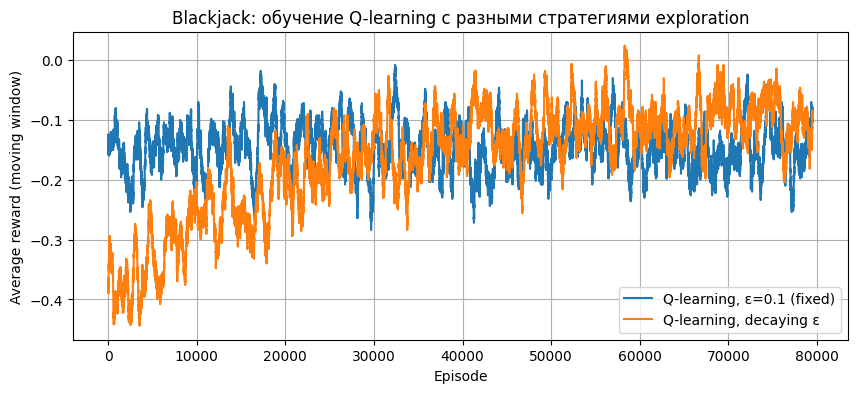

In [42]:
def moving_average(x, window=500):
    x = np.array(x)
    if len(x) < window:
        return x
    return np.convolve(x, np.ones(window) / window, mode="valid")

ma_fixed = moving_average(rewards_fixed, window=500)
ma_decay = moving_average(rewards_decay, window=500)

plt.figure(figsize=(10, 4))
plt.plot(ma_fixed, label="Q-learning, ε=0.1 (fixed)")
plt.plot(ma_decay, label="Q-learning, decaying ε")
plt.xlabel("Episode")
plt.ylabel("Average reward (moving window)")
plt.title("Blackjack: обучение Q-learning с разными стратегиями exploration")
plt.grid(True)
plt.legend()
plt.show()


In [43]:
def greedy_policy_from_Q(Q, n_actions):
    policy = {}
    for state, q_values in Q.items():
        policy[state] = int(np.argmax(q_values))
    return policy

n_actions = env.action_space.n
policy_fixed = greedy_policy_from_Q(Q_fixed, n_actions)
policy_decay = greedy_policy_from_Q(Q_decay, n_actions)


In [44]:
def evaluate_policy(env, policy, num_episodes=10000, gamma=1.0):
    total_return = 0.0

    for ep in range(num_episodes):
        state, info = env.reset()
        done = False
        G = 0.0
        power = 1.0

        while not done:
            action = policy.get(state, 0)
            next_state, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated

            G += power * reward
            power *= gamma

            state = next_state

        total_return += G

    avg_return = total_return / num_episodes
    return avg_return


In [45]:
avg_fixed = evaluate_policy(env, policy_fixed, num_episodes=5000)
avg_decay = evaluate_policy(env, policy_decay, num_episodes=5000)

print(f"Средний возврат (fixed ε):   {avg_fixed:.3f}")
print(f"Средний возврат (decay ε):   {avg_decay:.3f}")


Средний возврат (fixed ε):   -0.049
Средний возврат (decay ε):   -0.059


In [46]:
action_meanings = {
    0: "STICK",  # остановиться
    1: "HIT"     # взять карту
}

def play_episode_pretty(env, policy, max_steps=100):
    state, info = env.reset()
    done = False
    total_reward = 0.0
    step = 0

    print("\n" + "=" * 40)
    print("         NEW EPISODE (Blackjack)        ")
    print("=" * 40)

    # стартовые карты
    print(f"Initial state: {state}")
    print(f"  Рука игрока:  {hand_to_str(env.unwrapped.player)}")
    print(f"  Рука дилера: {hand_to_str(env.unwrapped.dealer)}")

    while not done and step < max_steps:
        print("\n" + "-" * 40)
        print(f"Step {step}")

        # состояние
        player_sum, dealer_card, usable_ace = state
        print(f"  State:")
        print(f"    player_sum   = {player_sum}")
        print(f"    dealer_card  = {dealer_card}")
        print(f"    usable_ace   = {bool(usable_ace)}")

        action = policy.get(state, 0)
        print(f"  Action: {action} ({action_meanings.get(action, '?')})")

        next_state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        total_reward += reward

        # карты после действия
        print(f"  Reward: {reward}")
        print(f"  Next state: {next_state}")
        print(f"  Player hand: {hand_to_str(env.unwrapped.player)}")
        print(f"  Dealer hand: {hand_to_str(env.unwrapped.dealer)}")
        print(f"  Done: {done}")

        state = next_state
        step += 1

    print("\n" + "=" * 40)
    print("       EPISODE FINISHED")
    print("=" * 40)
    print(f"Total steps:  {step}")
    print(f"Total reward: {total_reward}")

    if total_reward > 0:
        print("ЛЕГЧАЙШАЯ ДЛЯ ВЕЛИЧАЙШЕГО!!!!!!")
    elif total_reward < 0:
        print("Еб***ый рот этого казино бл***, ты кто такой, с***, чтоб это сделать?!")
    else:
        print("ничья")

    print("=" * 40 + "\n")

    return total_reward


In [47]:
def card_to_str(card):
    if card == 1:
        return "A"
    elif card == 10:
        return "10"
    else:
        return str(card)

def hand_to_str(hand):
    return "[" + " ".join(card_to_str(c) for c in hand) + "]"


In [56]:
#визуализировать в виде мультика не выходит(
# один эпизод с политикой decay-ε
_ = play_episode_pretty(env, policy_decay)




         NEW EPISODE (Blackjack)        
Initial state: (9, 4, 0)
  Рука игрока:  [5 4]
  Рука дилера: [4 3]

----------------------------------------
Step 0
  State:
    player_sum   = 9
    dealer_card  = 4
    usable_ace   = False
  Action: 1 (HIT)
  Reward: 0.0
  Next state: (16, 4, 0)
  Player hand: [5 4 7]
  Dealer hand: [4 3]
  Done: False

----------------------------------------
Step 1
  State:
    player_sum   = 16
    dealer_card  = 4
    usable_ace   = False
  Action: 0 (STICK)
  Reward: -1.0
  Next state: (16, 4, 0)
  Player hand: [5 4 7]
  Dealer hand: [4 3 10]
  Done: True

       EPISODE FINISHED
Total steps:  2
Total reward: -1.0
Еб***ый рот этого казино бл***, ты кто такой, с***, чтоб это сделать?!



In [60]:
_ = play_episode_pretty(env, policy_fixed)
#fixed ε


         NEW EPISODE (Blackjack)        
Initial state: (16, 6, 1)
  Рука игрока:  [5 A]
  Рука дилера: [6 7]

----------------------------------------
Step 0
  State:
    player_sum   = 16
    dealer_card  = 6
    usable_ace   = True
  Action: 1 (HIT)
  Reward: 0.0
  Next state: (13, 6, 0)
  Player hand: [5 A 7]
  Dealer hand: [6 7]
  Done: False

----------------------------------------
Step 1
  State:
    player_sum   = 13
    dealer_card  = 6
    usable_ace   = False
  Action: 1 (HIT)
  Reward: 0.0
  Next state: (15, 6, 0)
  Player hand: [5 A 7 2]
  Dealer hand: [6 7]
  Done: False

----------------------------------------
Step 2
  State:
    player_sum   = 15
    dealer_card  = 6
    usable_ace   = False
  Action: 1 (HIT)
  Reward: -1.0
  Next state: (25, 6, 0)
  Player hand: [5 A 7 2 10]
  Dealer hand: [6 7]
  Done: True

       EPISODE FINISHED
Total steps:  3
Total reward: -1.0
Еб***ый рот этого казино бл***, ты кто такой, с***, чтоб это сделать?!

